### Problem statement

Singlife has observed a concerning trend in the customer journey: potential policyholders are expressing hesitation and eventual disengagement during the insurance acquisition process. To address this, Singlife seeks to leverage its dataset. The objective is to <font size="4">**derive actionable insights from this data to enhance the customer experience**</font>. The challenge is to dissect the dataset to <font size="4">**uncover the critical touchpoints that contribute to customer drop-off and identify opportunities to streamline the application process and personalize communication**</font>. The ultimate goal is to <font size="4">**predict customer satisfaction and conversion rates, thereby bolstering Singlife's market position**</font>.


### Code


#### Import libraries and data


In [3]:
# %pip install pyarrow
# %pip install scikit-learn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import VarianceThreshold
import pyarrow
import os
from datetime import datetime
currWD = os.getcwd()
print("Current Working Directory:", currWD)
# os.chdir("Set WD here")
filepath = "./data/catB_train.parquet"
data = pd.read_parquet(filepath, engine='pyarrow')

Current Working Directory: /Users/swislar/Desktop/data/Datathon


#### Data cleaning


##### Summary of dataset


<strong><h4>Potential useful variables</h4></strong>
<strong><h5>1. General Client Information</h5></strong>

1. `clntnum` (Identifier)
2. `ctrycode_desc` (Nationality)
3. `stat_flag` (Used to identify curent/ past clients)
4. `min_occ_date`
5. `cltdob_fix`
6. `cltsex_fix` (Gender of client)
7. `cltage` (Age of client)
8. `cltage_start`
9. `clt_ten` (Customer tenure) </br>

<strong><h5>2. Client Risk and Status Indicators</h5></strong>

1. `flg_substandard` (substandard risk clients)
2. `flg_is_borderline_standard` (borderline standard risk clients)
3. `flg_is_revised_term` (client revised terms)
4. `flg_has_health_claim` (clients with health insurance claims)
5. `flg_gi_claim` (clients with general insurance claims)
6. `flg_is_proposal` (potential policy for client)

<strong><h5>3. Client Consent and Communication Preferences</h5></strong>

1. `is_consent_to_mail`, `is_consent_to_email`, `is_consent_to_call`, `is_consent_to_sms` (to find the best mode of communication)
2. `is_valid_dm`, `is_valid_mail`

<strong><h5>4. Demographic and Household Information</h5></strong>

1. `is_dependent_in_at_least_1_policy` (dependancy on a policy)
2. `annual_income_est` (estimated annual income)

<strong><h5>5. Policy and claim history</h5></strong>

1. `n_months_last_bought_products`, `flg_latest_being_lapse`, `flg_latest_being_cancel` (for determining potential client)
2. `tot_inforce_pols`, `tot_cancel_pols` (history of policies purchased)
3. `f_ever_declined_la` (rejected for policy)

<strong><h5>6. Anonymized Insurance Product Metrics (APE, Sum Insured, Prepaid Premiums)</h5></strong>

NA

<strong><h5>7. Other Flags and Metrics</h5></strong>

1. `f_elx`, `f_mindef_mha`, `f_retail` (working sector can also determine need for policy)

<strong><h5>8. Purchase and Lapse Metrics for Specific Products</h5></strong>

NA

<strong><h5>9. Target Column</h5></strong>

1. `f_purchase_lh` (Indicates if customer will purchase insurance in the next 3 months)


In [4]:
colNames = data.columns.to_list()
colsWithNA = []
colsWithNACount = []
colsWithNone = []
colsWithNoneCount = []
for names in colNames:
    containsNA = data[names].isna().any()
    containsNone = data[names].map(lambda x: x == "None").sum()
    if containsNA:
        colsWithNA.append(names)
        colsWithNACount.append(data[names].isna().sum())
    if containsNone:
        colsWithNone.append(names)
        colsWithNoneCount.append(containsNone)
print("Columns with missing data: \n", list(zip(colsWithNA, colsWithNACount)))
print("Number of columns with NA: ", len(colsWithNA))
print(list(zip(colsWithNone, colsWithNoneCount)))
print("Number of columns with None: ", len(colsWithNone))

Columns with missing data: 
 [('race_desc', 3996), ('ctrycode_desc', 20), ('cltsex_fix', 23), ('flg_substandard', 1014), ('flg_is_borderline_standard', 1014), ('flg_is_revised_term', 1014), ('flg_is_rental_flat', 1014), ('flg_has_health_claim', 1014), ('flg_has_life_claim', 1014), ('flg_gi_claim', 1014), ('flg_is_proposal', 1014), ('flg_with_preauthorisation', 1014), ('flg_is_returned_mail', 1014), ('is_consent_to_mail', 1014), ('is_consent_to_email', 1014), ('is_consent_to_call', 1014), ('is_consent_to_sms', 1014), ('is_valid_dm', 1014), ('is_valid_email', 1014), ('is_housewife_retiree', 1014), ('is_sg_pr', 1014), ('is_class_1_2', 1014), ('is_dependent_in_at_least_1_policy', 1014), ('f_ever_declined_la', 16759), ('hh_20', 2809), ('pop_20', 2809), ('hh_size', 2809), ('hh_size_est', 2809), ('annual_income_est', 2809), ('recency_lapse', 12592), ('recency_cancel', 17368), ('tot_cancel_pols', 17368), ('lapse_ape_ltc_1280bf', 12592), ('lapse_ape_grp_6fc3e6', 12592), ('lapse_ape_grp_de05ae',

##### General Client Information


<strong>Important potential variables</strong>

1. `clntnum` (Identifier)
2. `ctrycode_desc` (Nationality)
3. `stat_flag` (Used to identify curent/ past clients)
4. `min_occ_date`
5. `cltdob_fix`
6. `cltsex_fix` (Gender of client)

<strong>New variables</strong>

1. `cltage` (Age of client)
2. `cltage_start` (Age of policy occ)
3. `clt_ten` (Customer tenure)


In [5]:
# Filtering columns
columnNames = ["clntnum", "ctrycode_desc", "stat_flag", "min_occ_date", "cltdob_fix", "cltsex_fix",
               "flg_substandard", "flg_is_borderline_standard", "flg_is_revised_term", "flg_has_health_claim", "flg_gi_claim", "flg_is_proposal",
               "is_dependent_in_at_least_1_policy", "annual_income_est", "tot_inforce_pols", "tot_cancel_pols", "f_ever_declined_la",
               "f_purchase_lh"]
data = data.loc[:, columnNames]
print(data.shape)
# Filtering data to focus on Singaporeans
cilentsByCountry = data["ctrycode_desc"].value_counts()
cilentsByCountry_Percentage = cilentsByCountry*100/sum(cilentsByCountry)
pd.DataFrame(round(cilentsByCountry_Percentage, 5)
             ).head(n=5).rename(columns={'ctrycode_desc': "Percentage of clients by country"})
data = data[data["ctrycode_desc"] == "Singapore"]

(17992, 18)


Since our primary target audience are Singaporeans (98.98%), we will filter the data on `ctrycode_desc` based on the clients from Singapore. </br>

Drops rows with incomplete age data in `cltdob_fix` and `min_occ_date` </br>
Compute the current age of the client (`cltage`) using `cltdob_fix` </br>
And the age the client is interested in the policy (`cltage_start`) using `min_occ_date` </br>


In [6]:
# Drop rows with incomplete data for `cltdob_fix`
data['cltdob_fix'] = data['cltdob_fix'].replace("None", pd.NaT)
data = data.dropna(subset=['cltdob_fix'])
# Drop rows with incomplete data for `min_occ_date`
data['min_occ_date'] = data['min_occ_date'].replace("None", pd.NaT)
data = data.dropna(subset=['min_occ_date'])

# Convert cltdob_fix to datetime format and compute the client's age
currentDate = datetime.now()
data["cltdob_fix"] = data["cltdob_fix"].map(
    lambda x: datetime.strptime(x, "%Y-%m-%d"))
data["cltage"] = round(data["cltdob_fix"].map(lambda x: (
    (currentDate - x).days/365.25)).astype(int))

# Convert min_occ_date to datetime format and compute cltage_start
data["min_occ_date"] = data["min_occ_date"].map(
    lambda x: datetime.strptime(x, "%Y-%m-%d"))
data["cltage_start"] = (
    (data["min_occ_date"] - data["cltdob_fix"]).dt.days/365.25).round().astype(int)

# Computing the customer tenure
data["clt_ten"] = data["cltage"] - data["cltage_start"]

<strong>Important potential variables</strong>

1. `flg_substandard` (substandard risk clients)
2. `flg_is_borderline_standard` (borderline standard risk clients)
3. `flg_is_revised_term` (client revised terms)
4. `flg_is_rental_flat` (indicates wealth of client)
5. `flg_has_health_claim` (clients with health insurance claims)
6. `flg_gi_claim` (clients with general insurance claims)
7. `flg_is_proposal` (potential policy for client)


In [7]:
data["is_dependent_in_at_least_1_policy"].value_counts()

0.0    16758
Name: is_dependent_in_at_least_1_policy, dtype: int64

#### Data Analysis


(MIGHT NOT BE USED)</br>
Splitting the data into 2 main groups,

1. Those that we know their decision to the purchase of insurance policies (Group 1)
2. Those that their decision is not known (Group 2)


In [8]:
predictDataIndex = np.where(data["f_purchase_lh"].isna())
completeDataIndex = np.where(~data["f_purchase_lh"].isna())
# Group 1
completeData = data.iloc[completeDataIndex]
# Group 2
predictData = data.iloc[predictDataIndex]

print(completeData["f_purchase_lh"])

18769    1.0
2781     1.0
19853    1.0
14239    1.0
18698    1.0
        ... 
7574     1.0
18141    1.0
3561     1.0
12206    1.0
10627    1.0
Name: f_purchase_lh, Length: 708, dtype: float64


##### Graph plots


To keep clients in the policy programme, we can filter for clients based on:

1. `f_purchase_lh` == NaN (Client not purchased insurance)
2. `flg_gi_claim` == (0 or NaN) (Client without gi insurance)
3. `flg_has_health_claim`== (0 or NaN) (Client without health insurance)

and perform the analysis based on the clients:

1. `cltage` - age
2. `clt_ten` - age the customer viewed policies


In [9]:
dataset1 = data[data["f_purchase_lh"].isna()]  # filter based on 1
dataset1 = dataset1[(dataset1["flg_gi_claim"] == 0 |
                     dataset1["flg_gi_claim"].isna())]  # filter based on 2
dataset1 = dataset1[(dataset1["flg_has_health_claim"] == 0 |
                     dataset1["flg_has_health_claim"].isna())]  # filter based on 3
dataset1.shape

(14862, 21)

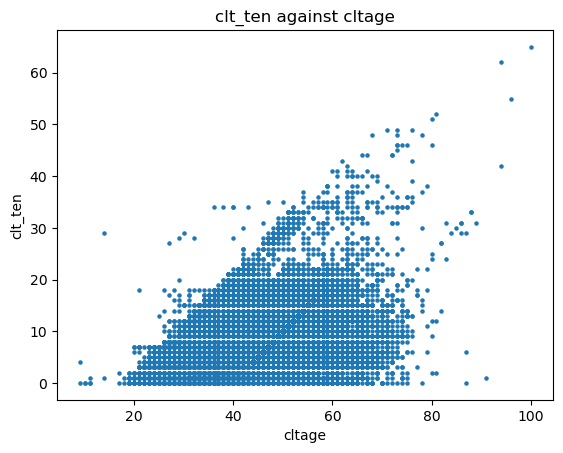

In [10]:
# RUBBISH PLOT
plt.scatter(dataset1["cltage"], dataset1["clt_ten"], marker="o", s=5)
plt.xlabel("cltage")
plt.ylabel("clt_ten")
plt.title("clt_ten against cltage")

plt.show()

# False data can be seen when clt_ten > cltage since they cannot be customers before 0 years old

In [11]:
dataset1["annual_income_est"].head()

19550     C.60K-100K
4600       D.30K-60K
13337    A.ABOVE200K
15074    B.100K-200K
19724     E.BELOW30K
Name: annual_income_est, dtype: object

In [14]:
print(dataset1.columns.size)
dataset1.columns

21


Index(['clntnum', 'ctrycode_desc', 'stat_flag', 'min_occ_date', 'cltdob_fix',
       'cltsex_fix', 'flg_substandard', 'flg_is_borderline_standard',
       'flg_is_revised_term', 'flg_has_health_claim', 'flg_gi_claim',
       'flg_is_proposal', 'is_dependent_in_at_least_1_policy',
       'annual_income_est', 'tot_inforce_pols', 'tot_cancel_pols',
       'f_ever_declined_la', 'f_purchase_lh', 'cltage', 'cltage_start',
       'clt_ten'],
      dtype='object')

To improve the efficiency in registration and communication,


To increase the satisfaction of the customers and keep them in the programme, we need to determine the most effective method of communication with the clients
